In [1]:
%load_ext autoreload
%autoreload 2

import scipy.optimize as opt
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
import robi
from tqdm import tqdm
import time
import torch
import seaborn as sns

def new_dataset(n_samples, censoring, nb_features, n_informative, noise):

    X, Y, coef = make_regression(n_samples=n_samples,
                           n_features=nb_features,
                           n_informative=n_informative,
                           noise=noise, coef=True)

    Y += abs(np.min(Y))

    def get_observed_time(x):
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = Y < time_censor
        time = np.where(event, Y, time_censor)
        return event, time

    def censoring_amount(x):
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - censoring)**2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount,
                              method="bounded",
                              bounds=(0, Y.max()))

    # compute observed time
    event, time = get_observed_time(res.x)

    # upper time limit such that the probability
    # of being censored is non-zero for `t > tau`
    tau = time[event].max()
    mask = time < tau
    X = X[mask]
    Y = Y[mask]
    event = event[mask]

    df = pd.DataFrame(data=X)
    df['time'] = Y
    df['event'] = event
    df.columns = df.columns.values.astype(str)

    return df, coef

In [16]:
n_workers=7
n_random=1e4
n_permut_nfp=100
device='cuda'

def do_trial():
    params = {
        'n_samples': np.random.randint(2, 1000)*1,
        'censoring': np.round(np.random.uniform(0.1, 1.),2),
        'nb_features': np.random.randint(2, 1000),
        'noise': np.round(np.random.uniform(0., 10.),2),
    }
    params['n_informative'] = np.random.randint(1, params['nb_features'])

    df, coef = new_dataset(**params)

    candidates = df.drop(columns=['time', 'event']).columns.tolist()

    res,_ = robi.make_selection(df,
                                candidates=candidates,
                                targets = {
                                  'time': ('time', 'event'),
                                },
                                n_workers=n_workers,
                                n_random=n_random,
                                n_permut_nfp=n_permut_nfp,
                                verbose=False,
                                max_corr=1,
                                device=device)

    res['coef_sel'] = [coef[np.array(x).astype('int64')].tolist() for x in res['sel_time']]

    res['actual_nfp'] = [(np.array(x)==0).sum() for x in res['coef_sel']]
    res['actual_ntp'] = [(np.array(x)!=0).sum() for x in res['coef_sel']]

    return res

In [17]:
all_nsel_by_permissiveness = []
for _ in tqdm(range(10)):
    try:
        r = do_trial()
        all_nsel_by_permissiveness.append(r)
        dfr = pd.concat(all_nsel_by_permissiveness)
        # with open('res_siminf.pickle', 'wb') as handle:
        #     pickle.dump(dfr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    except:
        time.sleep(1)

    torch.cuda.empty_cache()

 30%|███       | 3/10 [01:33<03:37, 31.12s/it]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
print(f"n synth: {dfr.loc[0.01].shape[0]}")

n synth: 10


<Axes: xlabel='permissiveness', ylabel='actual_nfp'>

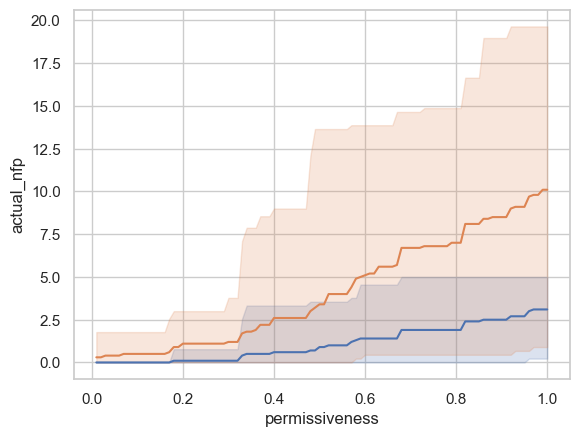

In [15]:
sns.lineplot(dfr, x='permissiveness', y='actual_nfp', errorbar=('pi',95))
sns.lineplot(dfr, x='permissiveness', y='n_sel_time', errorbar=('pi',95))

In [18]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
